In [18]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

## Model
<figure><img src="../../../images/hill model.png\" width=400 />


## Deduction

   $ F_{SEE} = \left\{\begin{array}{l}
   0\ \ , \ \ L_T < L_{SL}\\
   K(L - L_{SL})^2 \ \ , \ \ L_T \geq L_{SL}\\
   \end{array}
   \right.$
   
   $F_{KPE} = \left\{\begin{array}{l}
   0\ \ , \ \ L_{CE} < L_{op}\\
   K(L - L_{op})^2 \ \ , \ \ L_{CE} \geq L_{op}\\
   \end{array}
   \right.$
     
  
   $F = \frac{F_{SEE}}{cos(\alpha)} - F_{KPE} = F_{CE} $
     
   $\dot L_{CE} = (0.25 + 0.75a)V_{max}\frac{F_{CE}-aF_L}{b} $
   
   $ b = \left\{\begin{array}{l}
   aF_L + F_{CE}/A_f\ \ , \ \ F_{CE} < F_L\\
   \frac{(2 + 2/A_f)(aF_L\overline{F}^M_{len} - F_{CE})}{\overline{F}^M_{len} - 1}   \ \ , \ \ F_{CE} \geq F_L\\
   \end{array}
   \right.$
   
   $\frac{da}{dt} = \frac{u - a}{\tau_a(u,a)}$
   
   $\tau_a(a,u) = \left\{\begin{array}{l}
   \tau_{act}(0.5 + 1.5a)\ \ , \ \ u > a\\
   \frac{\tau_{dact}}{(0.5 + 1.5a)}\ \ , \ \ u \leq a\\
   \end{array}
   \right.$
   
   $L_{SEE} = L_m - L_{CE} cos(\alpha)$

## Parameters

In [19]:
## Muscle properties for human Vastus Lateralis

L_SL = 0.223 #slack length of SEE, SEE strain at Fmax (meters)
L_CEOPT = 0.093 #optimal length of CE (meter)
Fmax = 7400 #maximal isometric force (Newton)
width = 0.63 #max relative length change of CE
alpha = 0 #degree

 
##parameters for the equation of motion (Nigg & Herzog, p. 562)
m = 10 #kg
Rcm = 0.264 #distance knee joint to centre of mass(meter)
I = 0.1832  #moment of inertia
Rf = 0.033 #moment arm of quadriceps

## Condições Iniciais
phi = np.pi/2
phid = 0 #start as 90 degree flexion and zero velocity
L_CE_norm = (0.31 - L_SL)/L_CEOPT #make sure that SEE is just slack at t=0
#L_CE_norm = 0.087/L_CEOPT #make sure that SEE is just slack at t=0


alpha = np.pi*alpha/180 #convert to rad
L_SL_norm = L_SL/L_CEOPT
dt = 0.001
t = np.arange(0,3,dt)
a =  np.empty_like(t)
F_tendon_norm = np.empty_like(t)
F_kpe_norm = np.empty_like(t)
F_CE_norm = np.empty_like(t)
F_tot = np.empty_like(t)
fiber_length = np.empty_like(t)
tendon_length = np.empty_like(t)
angle_phi = np.empty_like(t)
velocity_phi = np.empty_like(t)
aux = 0

## Functions

In [20]:
def computeTendonForce(L_SEE_norm,L_SL_norm):
    """
    ComputeTendonForce
    
    Inputs:
    
        L_SEE_norm - Normalized tendon length
    
        L_SL_norm - Normalized slack length of the tendon
    
        L_CEOPT = Optimal length of the fiber
        
    Output:
        F_tendon_norm - Normalized tendon force
    
    """
    Umax = 0.04
    
    if L_SEE_norm < L_SL_norm:
        F_tendon_norm = 0
    else:
        F_tendon_norm =  ((L_SEE_norm - L_SL_norm)/(Umax*L_SL_norm))**2
        
    return F_tendon_norm

In [21]:
def computeParalelElementForce(L_CE_norm):
    """
    Compute Paralel Elemento Force
    
    Inputs:
    
        L_CE_norm - Normalized Contract Element length
    
        L_SL_norm - Normalized slack length of the tendom
    
        L_CEOPT = Optimal length of the fiber
        
    Output:
        F_kpe_norm - Normalized paralel element force
    
    """
    
    Umax = 1
    
    if L_CE_norm < 1:
        F_kpe_norm = 0
    else:
        F_kpe_norm = ((L_CE_norm - 1)/(Umax*1))**2
        
    return F_kpe_norm

In [22]:
def computeForceLengthCurve(L_CE_norm,width):
    """
    Compute Force Length Curve
    
    Inputs:
    
        L_CE_norm - Normalized Contract Element length
        
    Output:
        F_Lnorm - Normalized Force Length Element
    
    """
    
    F_Lnorm = max(0,(1-((L_CE_norm-1)/width)**2))
        
    return F_Lnorm

In [23]:
def dLCEdt(F_Lnorm, F_CE_norm,a):
    """"
    Incremental Contract Element's length
    
    Inputs:
    
        F_Lnorm - Normalized Force Length Element
        
        F_kpe_norm - Normalized paralel element force
        
    Output:
        L_CE_dot - Incremental Contract Element's length
             
    """
    A = 0.25
    F_m_len = 1.4 #young
    #F_m_len = 1.8 #old
    v_max = 10 #young
    #v_max = 8 #old
    
    FCE = min(a*F_Lnorm*F_m_len-0.0001,F_CE_norm)
    
    if FCE <= a*F_Lnorm:
        b = a*F_Lnorm + FCE/A
        
    else:
        b = (2 + 2/A)*(a*F_Lnorm*F_m_len - FCE)/(F_m_len - 1)
        
    L_CE_dot = (0.25 + 0.75*a)*v_max*(FCE - a*F_Lnorm)/b

    return L_CE_dot

In [24]:
def computeTendonLength(L_m,L_CEOPT,L_CE_norm,alpha):
    """
    ComputeTendonLength
    
    Inputs:
    
        L_m - Normalized muscle length
    
        L_CEOPT - Optimal length of the fiber
    
        L_CE_norm - Nomalized Contract Element Lenght
        
        alpha - Angle between tendon and fiber
        
    Output:
        L_SEE_norm - Normalized slack length
    
    """

    L_SEE_norm = L_m/L_CEOPT - L_CE_norm*np.cos(alpha)
    
    return L_SEE_norm

In [25]:
def computeForceContract(F_tendon_norm,F_kpe_norm,alpha ):
    """"
    Incremental Contract Element's length
    
    Inputs:
    
        F_tendon_norm - Normalized tendon force
        
        F_CE_norm - Normalized Contract Element Force
        
        alpha - Angle between tendon and fibers (rad)
        
    Output:
        F_kpe_norm - Normalized paralel element force
      
    """
    
    F_CE_norm = F_tendon_norm/np.cos(alpha) - F_kpe_norm
        
    return F_CE_norm

In [26]:
def computeActivation(a,u,dt):
    """
    Compute Activation parameter
    
    Inputs:
    
        a - Muscle activation parameter
        
        u - Muscle excitation signal
        
        dt - time step
        
    Output:
        a - Muscle activation parameter
    
    """
    tau_dact = 50e-3 #young #ms
    #tal_dact = 0.060 #old #ms
    tau_act = 15e-3 #ms
    
    if u > a:
        tau_a = tau_act*(0.5 + 1.5*a)
    else:
        tau_a = tau_dact/(0.5 + 1.5*a)
    
    dadt = (u-a)/tau_a # euler
    
    a += dadt*dt
    
    return a

In [27]:
def computeMomentKnee(Rf,F,m,Rcm,phi,Fmax):
    """
    Compute Force Length Curve
    
    Inputs:
    
        L_CE_norm - Normalized Contract Element length
        
    Output:
        F_Lnorm - Normalized Force Length Element
    
    """
    g = 9.81
    
    M = Rf*F*Fmax - m*g*Rcm*np.sin(phi-np.pi/2)
        
    return M

In [28]:
def computeFlexionAngleVelocity(M,I):

    phidd = M/I #angular acceleration
    
    return phidd

## Muscle Model

In [29]:
for i in range(len(t)):
    
    #inputs
    
    L_m = 0.31 - (phi-np.pi/2)*Rf #total muscle-tendon length from joint angle
    
    if t[i] <= 1:
        u1 = 1
    elif t[i] <= 3:
        u1 = 0.5
    else:
        u1 = 0.1
    
    u2 = 0.2*np.sin(np.pi*t[i]) + 0.7
    
    if 1 <= t[i] <= 3 :
        u3 = 1
    else:
        u3 = 0.01
        
    u4 = 1
    
        
    #################################################################################################################
        
    L_SEE_norm = computeTendonLength(L_m,L_CEOPT,L_CE_norm,alpha)
    
    F_tendon_norm[i] = computeTendonForce(L_SEE_norm,L_SL_norm)
        
    F_kpe_norm[i] = computeParalelElementForce(L_CE_norm)
        
    F_Lnorm = computeForceLengthCurve(L_CE_norm,width)
    
    F_CE_norm[i] = computeForceContract(F_tendon_norm[i],F_kpe_norm[i],alpha)
    
    a[i] = computeActivation(aux,u4,dt)
    aux = a[i]
        
    L_CE_norm = L_CE_norm + dt*dLCEdt(F_Lnorm,F_CE_norm[i],a[i])
    
    M =  computeMomentKnee(Rf,F_tendon_norm[i],m,Rcm,phi,Fmax) # total moment with respect to knee joint
    
    phid = phid+ dt*computeFlexionAngleVelocity(M,I)
    
    phi += phid*dt
    
    #################################################################################################################
    
    F_tot[i] = F_tendon_norm[i]*Fmax
    fiber_length[i] = L_CE_norm*L_CEOPT
    tendon_length[i] = L_SEE_norm*L_CEOPT
    velocity_phi[i] = phid
    angle_phi[i] = phi
    
        

    

## Normalizade Tendon Force

<IPython.core.display.Javascript object>


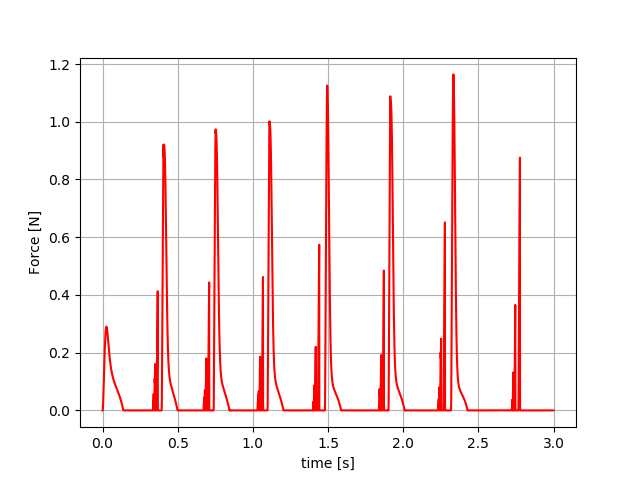

Text(0,0.5,'Force [N]')

In [30]:
plt.figure()
plt.plot(t,F_tendon_norm, c = 'red')
plt.grid()
plt.xlabel ('time [s]')
plt.ylabel ('Force [N]')

## Tendon Force

<IPython.core.display.Javascript object>


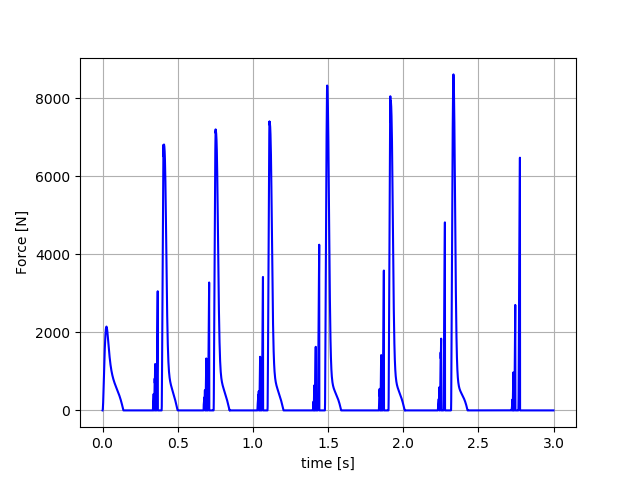

Text(0,0.5,'Force [N]')

In [31]:
plt.figure()
plt.plot(t,F_tot, c = 'blue')
plt.grid()
plt.xlabel ('time [s]')
plt.ylabel ('Force [N]')

## Length

<IPython.core.display.Javascript object>


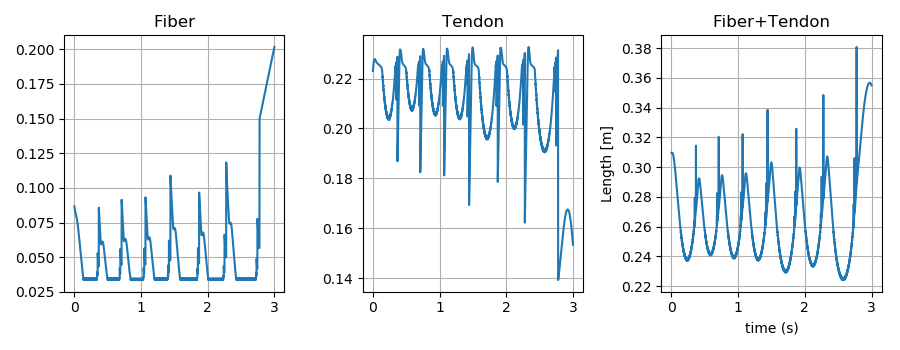

In [32]:
fig,  ax  =  plt.subplots(1, 3, figsize=(9, 3.5), sharex=True)

ax[0].plot(t, fiber_length, label = 'Fiber')
ax[0].set_title('Fiber')
ax[0].grid()
ax[1].plot(t, tendon_length, label = 'Tendon')
ax[1].set_title('Tendon')
ax[1].grid()
ax[2].plot(t, fiber_length+tendon_length, label = 'Fiber+Tendon')
ax[2].set_title('Fiber+Tendon')
ax[2].grid()
plt.xlabel('time (s)')
plt.ylabel('Length [m]')
plt.tight_layout()


## Activation

<IPython.core.display.Javascript object>


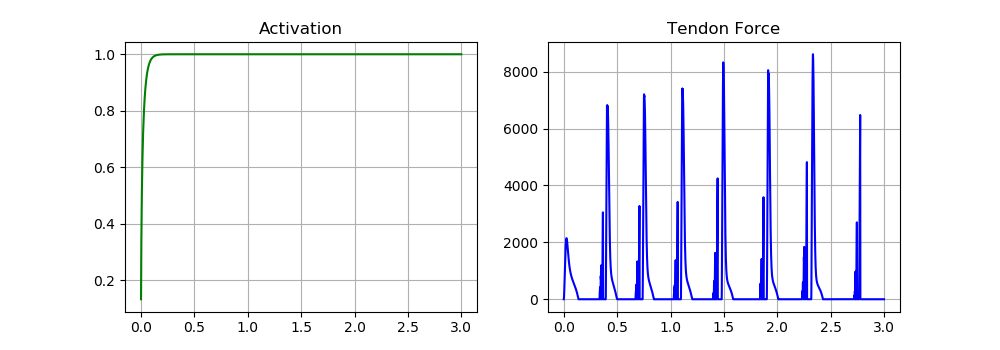

In [33]:
fig,  ax  =  plt.subplots(1, 2, figsize=(10, 3.5), sharex=True)

ax[0].plot(t, a, c = 'green')
ax[0].set_title('Activation')
ax[0].grid()
ax[1].plot(t, F_tot, c = 'blue')
ax[1].set_title('Tendon Force')
ax[1].grid()

<IPython.core.display.Javascript object>


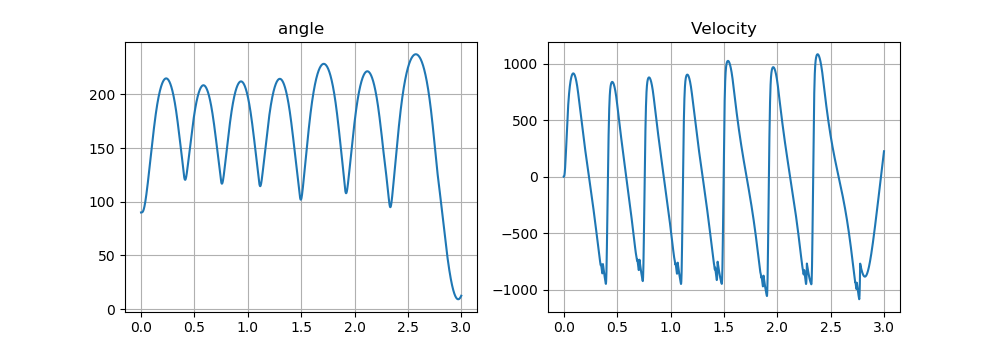

In [34]:
fig,  ax  =  plt.subplots(1, 2, figsize=(10, 3.5), sharex=True)

ax[0].plot(t, angle_phi*180/np.pi)
ax[0].set_title('angle')
ax[0].grid()
ax[1].plot(t, velocity_phi*180/np.pi)
ax[1].set_title('Velocity')
ax[1].grid()